In [1]:
import numpyro
numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)

import arviz as az
import numpy as np
import pandas as pd
import jax.numpy as jnp
from cycler import cycler
import matplotlib
import matplotlib.pyplot as plt
from jax import random, jit, lax, pmap, vmap
from corner import corner, overplot_points, overplot_lines
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, init_to_uniform, init_to_feasible, Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro.optim import Adam
from eggman.infer import Star
from functools import partial

rng = random.PRNGKey(42)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
I0000 00:00:1696407400.890663   58101 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
dist = numpyro.distributions

In [3]:
class TrueStar(Star):
    max_distance = 500.  # parsecs
    max_av = 1.
    
    def prior(self, const):
        x = numpyro.sample("x", dist.Uniform(0.0, 0.999))
        ln_mass = numpyro.sample("ln_mass", dist.TruncatedNormal(-0.2, 0.7, low=jnp.log(0.7), high=jnp.log(2.3)))
        y = numpyro.sample("Y", dist.Uniform(0.22, 0.32))
        mh = numpyro.sample("M_H", dist.TruncatedNormal(0.0, 0.5, low=-0.9, high=0.5))
        a_mlt = numpyro.deterministic("a_MLT", 2.0)
        
        # This is the inverse of a Beta distribution where beta = 1
        # In particular, alpha = 3 is the inverse of a distance^2 distribution
        plx = numpyro.sample("plx", dist.Pareto(1/self.max_distance, 3.0))
        
        # This is just p(av) ~ av^(alpha - 1)
        av_scaled = numpyro.sample("Av_scaled", dist.Beta(2., 1.))
        av = numpyro.deterministic("Av", self.max_av * av_scaled)
        return x, ln_mass, y, mh, a_mlt, plx, av

In [4]:
num_stars = 10

true_model = TrueStar()
# true_model._x_bounds = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])
# true_model._eep_funclist = true_model._get_eep_funclist()

rng, key = random.split(rng)
pred = Predictive(true_model, num_samples=num_stars)
const = {}
truths = pred(key, const)

Beta dist with beta = 1 is just a bounded power law dist where the power is (alpha - 1)

In [5]:
from numpyro.distributions.util import clamp_probs

class TwoSidedTruncatedDistribution(dist.TwoSidedTruncatedDistribution):
    def icdf(self, u):
        loc = self.base_dist.loc
        sign = jnp.where(loc >= self.low, 1.0, -1.0)
        return (1 - sign) * loc + sign * self.base_dist.icdf(
            clamp_probs((1 - u) * self._tail_prob_at_low + u * self._tail_prob_at_high)
        )

def TruncatedNormal(loc=0.0, scale=1.0, *, low=None, high=None, validate_args=None):
    return TwoSidedTruncatedDistribution(
        dist.Normal(loc, scale), low=low, high=high, validate_args=validate_args
    )

In [6]:
from eggman.infer.models import lognorm_from_norm

class NewStar(Star):
    def prior(self, const):
        x = numpyro.sample("x", dist.Uniform(0.0, 0.999))
#         x = numpyro.sample("x", TruncatedNormal(0.5, 2.0, low=0.0, high=1.0))
        # ln_mass = numpyro.sample("ln_mass", LogSalpeter(jnp.log(0.7), jnp.log(2.3), rate=2.35))
        # Good approximation of Chabrier IMF
        ln_mass = numpyro.sample("ln_mass", TruncatedNormal(-0.2, 0.7, low=jnp.log(0.7), high=jnp.log(2.3)))
#         ln_mass = numpyro.sample("ln_mass", TruncatedNormal(np.log(1.7), 0.4, low=jnp.log(0.7), high=jnp.log(2.3)))
#         ln_mass = numpyro.sample("ln_mass", dist.Uniform(0.7, 2.3))
#         ln_mass = jnp.log(ln_mass)

        y = numpyro.sample("Y", dist.Uniform(0.22, 0.32))
#         y = numpyro.sample("Y", TruncatedNormal(0.26, 0.1, low=0.22, high=0.32))
        
        mh = numpyro.sample("M_H", TruncatedNormal(const["M_H"]["mu"], const["M_H"]["sigma"], low=-0.9, high=0.5))
        
        a_mlt = numpyro.sample("a_MLT", dist.Uniform(1.3, 2.7))
#         a_mlt = numpyro.sample("a_MLT", TruncatedNormal(2.0, 2.0, low=1.3, high=2.7))
        
        plx_dist = dist.LogNormal(*lognorm_from_norm(const["plx"]["mu"], const["plx"]["sigma"]))
        plx = numpyro.sample("plx", plx_dist)

        av_dist = dist.LogNormal(*lognorm_from_norm(const["Av"]["mu"], const["Av"]["sigma"]))            
        av = numpyro.sample("Av", av_dist)

        return x, ln_mass, y, mh, a_mlt, plx, av

In [7]:
model = NewStar()
model.dof = 10

for band in model.bands:
    const[band] = dict(sigma=3e-3)

In [8]:
i = -1
const["M_H"] = dict(mu=truths["M_H"][i], sigma=0.1)
const["plx"] = dict(mu=truths["plx"][i], sigma=4e-5)
const["Av"] = dict(mu=truths["Av"][i], sigma=0.01*truths["Av"][i])
obs = {key: truths[key][i] for key in model.bands}

In [9]:
num_steps = 5000
num_chains = 10

guide = AutoDelta(model, init_loc_fn=init_to_uniform)
optim = Adam(step_size=0.01)
loss = Trace_ELBO()

svi = SVI(model, guide, optim, loss)

run_svi = partial(svi.run, num_steps=num_steps, const=const, obs=obs, progress_bar=False)

In [10]:
%%time
keys = random.split(rng, num_chains+1)
rng, key = keys[0], keys[1:]
svi_result = pmap(run_svi)(key)

CPU times: user 7.16 s, sys: 328 ms, total: 7.49 s
Wall time: 7 s


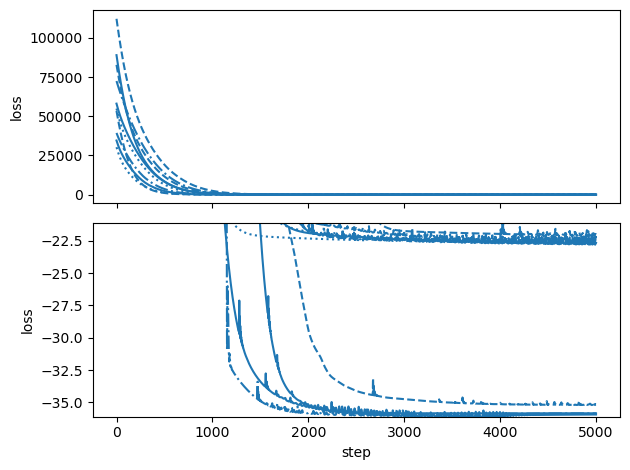

In [11]:
fig, axes = plt.subplots(2, sharex=True)

# cycle = matplotlib.rcParams["axes.prop_cycle"] * cycler(ls=["-", "--", "-.", ":"])
cycle = cycler(ls=["-", "--", "-.", ":"])
ylim = np.quantile(svi_result.losses, [0., .66])

ax = axes[0]
ax.set_prop_cycle(cycle)
ax.plot(svi_result.losses.T)
ax.axhspan(*ylim, alpha=0.33)
ax.set_ylabel("loss")

ax = axes[1]
ax.set_prop_cycle(cycle)
ax.plot(svi_result.losses.T)
ax.set_ylim(ylim)
ax.set_ylabel("loss")
ax.set_xlabel("step")

fig.tight_layout()

In [12]:
sampler = NUTS(model)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=num_chains)

In [13]:
rng, key = random.split(rng)

init_params = {k[:-9]: v for k, v in svi_result.params.items()}
# init_params = {k[:-9]: truths[k[:-9]] for k, v in svi_result.params.items()}
# init_params = {k[:-9]: np.broadcast_to(v[i_best], (num_chains,)) for k, v in svi_result.params.items()}

extra_fields = ("adapt_state.step_size", "accept_prob", "num_steps")
mcmc.warmup(key, const, extra_fields=extra_fields, collect_warmup=True, obs=obs, 
            init_params=init_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
fields = mcmc.get_extra_fields(group_by_chain=True)
step_size = fields["adapt_state.step_size"]
accept_prob = fields["accept_prob"]
num_steps = fields["num_steps"]
tree_depth = np.log2(num_steps).astype(int) + 1.

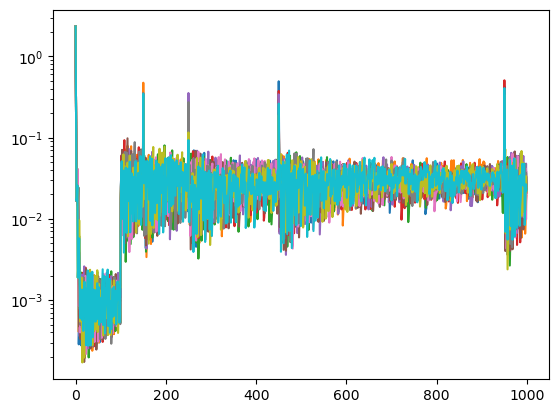

In [15]:
plt.plot(step_size.T)
plt.yscale("log");

In [16]:
def polish_traceplot(fig, axes):
    for ax in axes[:, 0]:
        title = ax.get_title()
        ax.set_xlabel(title)
        ax.set_title(None)
    for ax in axes[:, 1]:
        title = ax.get_title()
        ax.set_xlabel("step")
        ax.set_ylabel(title)
        ax.set_title(None)

    fig = plt.gcf()
    fig.align_labels()
    fig.tight_layout() 
    return fig, axes

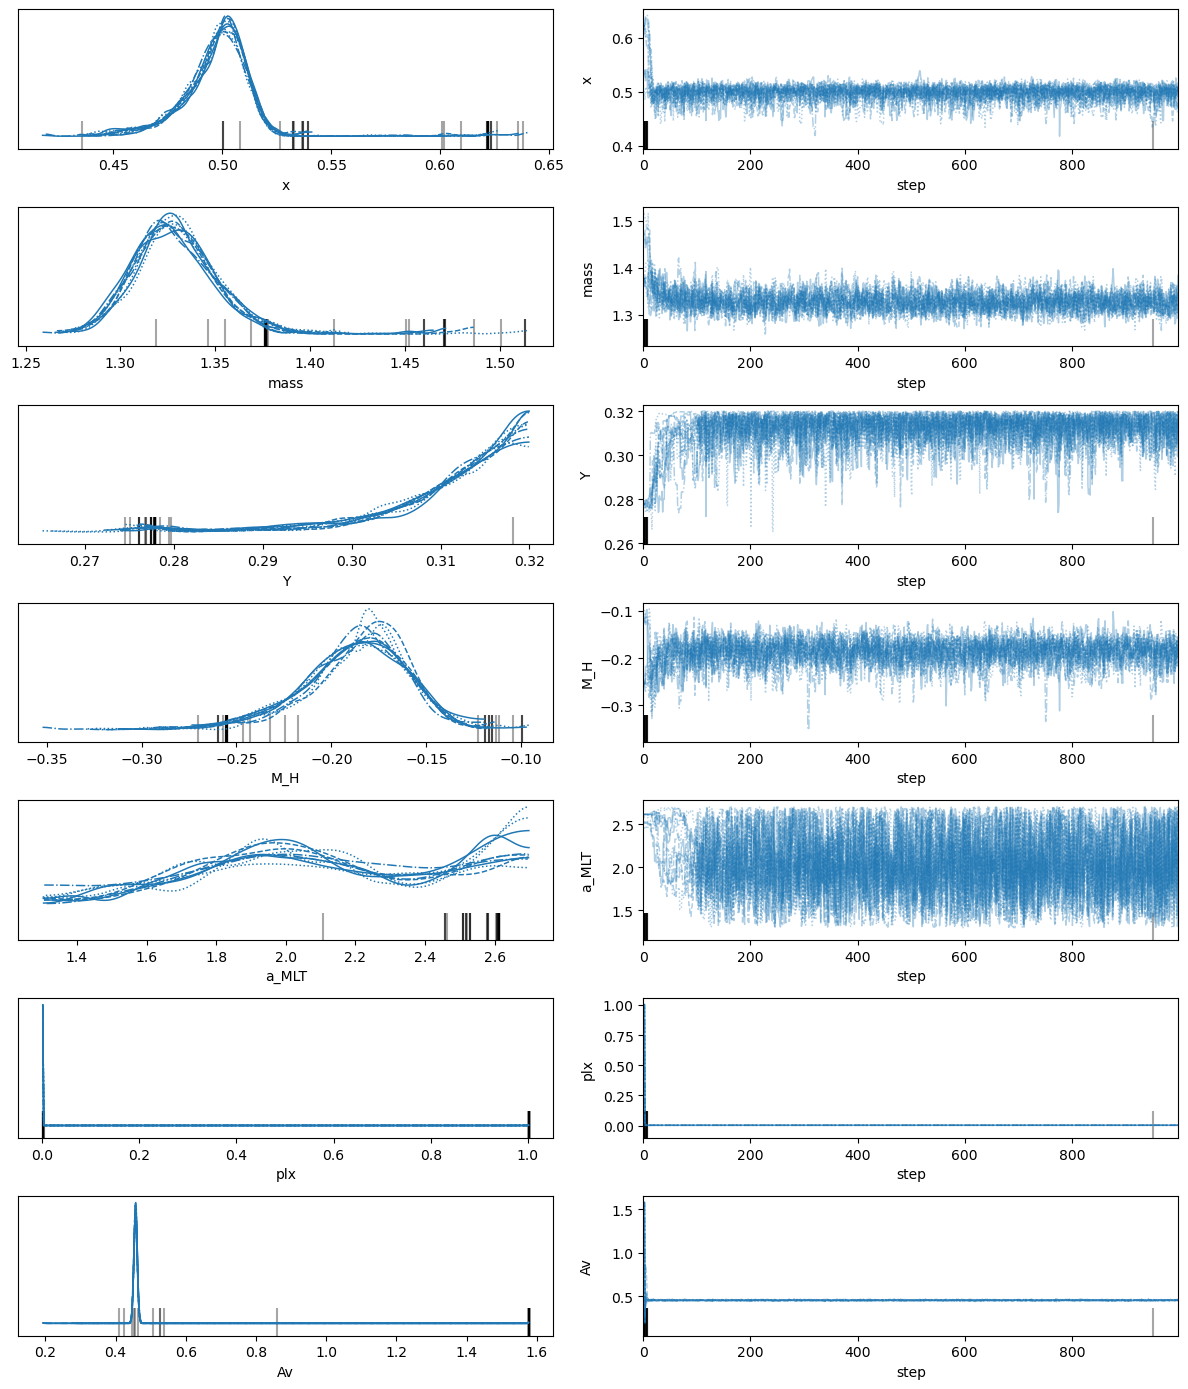

In [17]:
var_names = [
    "x", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT", 
    "plx",
    "Av",
]
backend_kwargs = {"tight_layout": True}

axes = az.plot_trace(az.from_numpyro(mcmc), var_names=var_names, backend_kwargs=backend_kwargs)
_ = polish_traceplot(plt.gcf(), axes)

In [18]:
rng, key = random.split(rng)
mcmc.run(key, const, extra_fields=extra_fields, obs=obs)
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      0.46      0.00      0.46      0.45      0.46   7455.13      1.00
       M_H     -0.19      0.03     -0.18     -0.23     -0.15   3300.04      1.00
         Y      0.31      0.01      0.31      0.30      0.32   4268.04      1.00
     a_MLT      2.05      0.38      2.03      1.53      2.70   5165.43      1.00
   ln_mass      0.28      0.02      0.28      0.26      0.31   3379.67      1.00
       plx      0.00      0.00      0.00      0.00      0.00   3621.17      1.00
         x      0.50      0.01      0.50      0.47      0.52   3478.83      1.00

Number of divergences: 0


In [19]:
data = az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

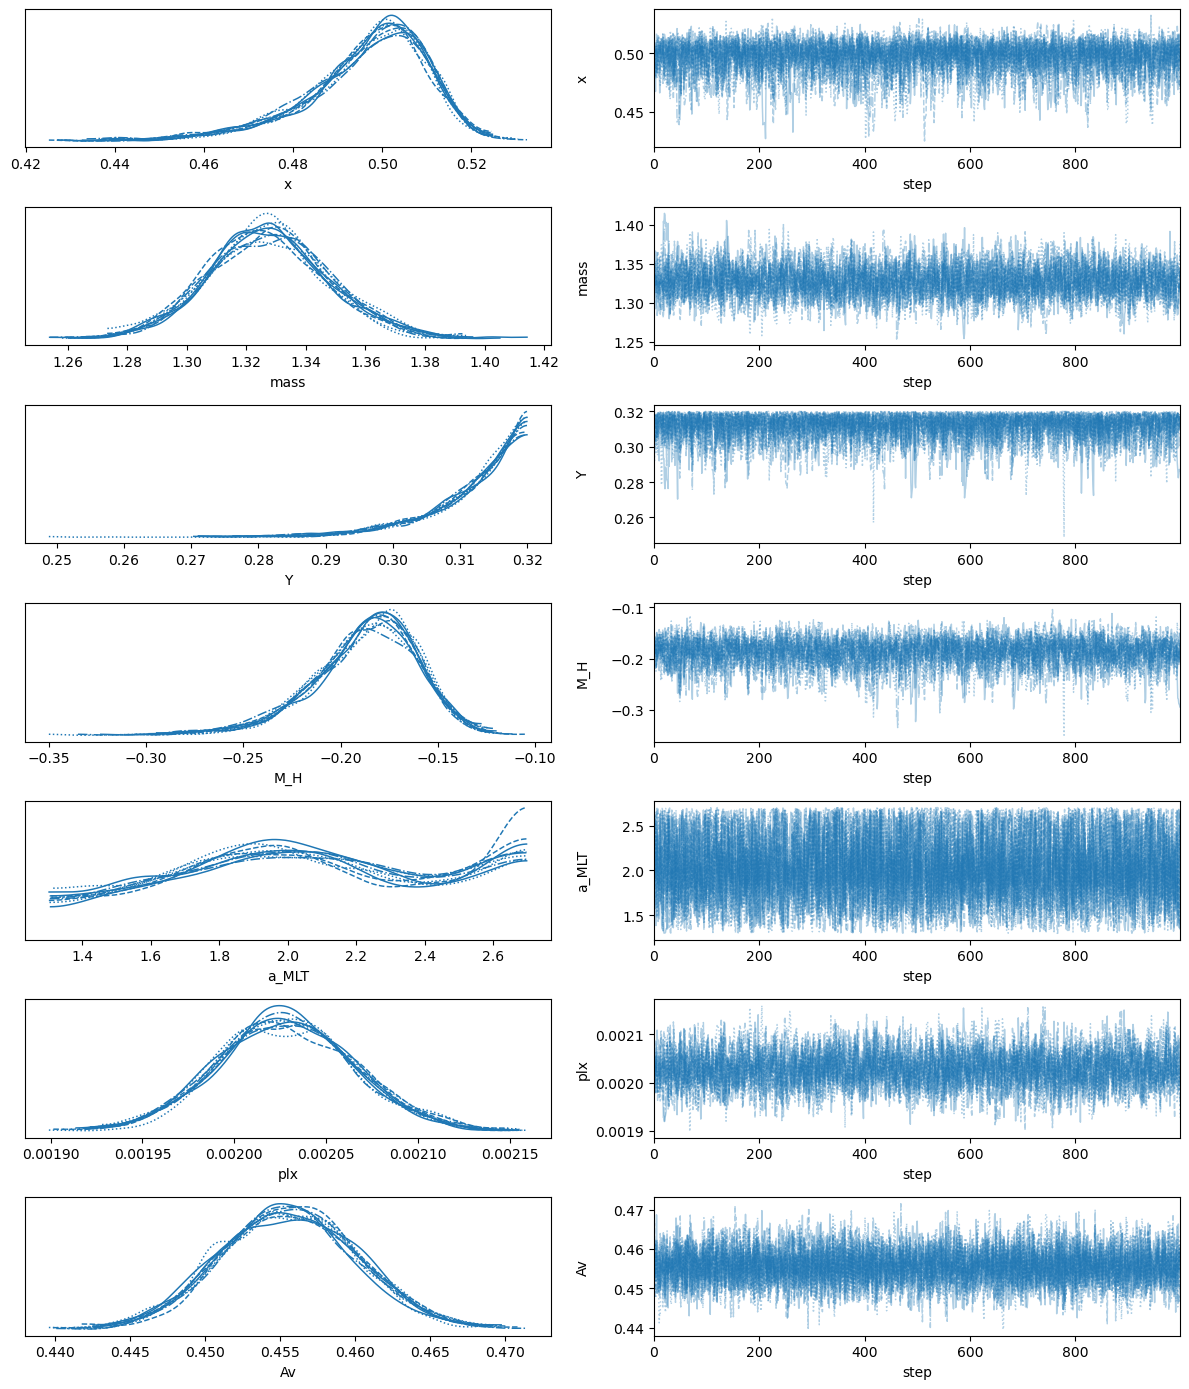

In [20]:
backend_kwargs = {"tight_layout": True}
axes = az.plot_trace(data, var_names=var_names, backend_kwargs=backend_kwargs)

_ = polish_traceplot(plt.gcf(), axes)

In [21]:
rng, key = random.split(rng)

predict = Predictive(model, posterior_samples=init_params)
init_params.update(predict(key, const, obs))

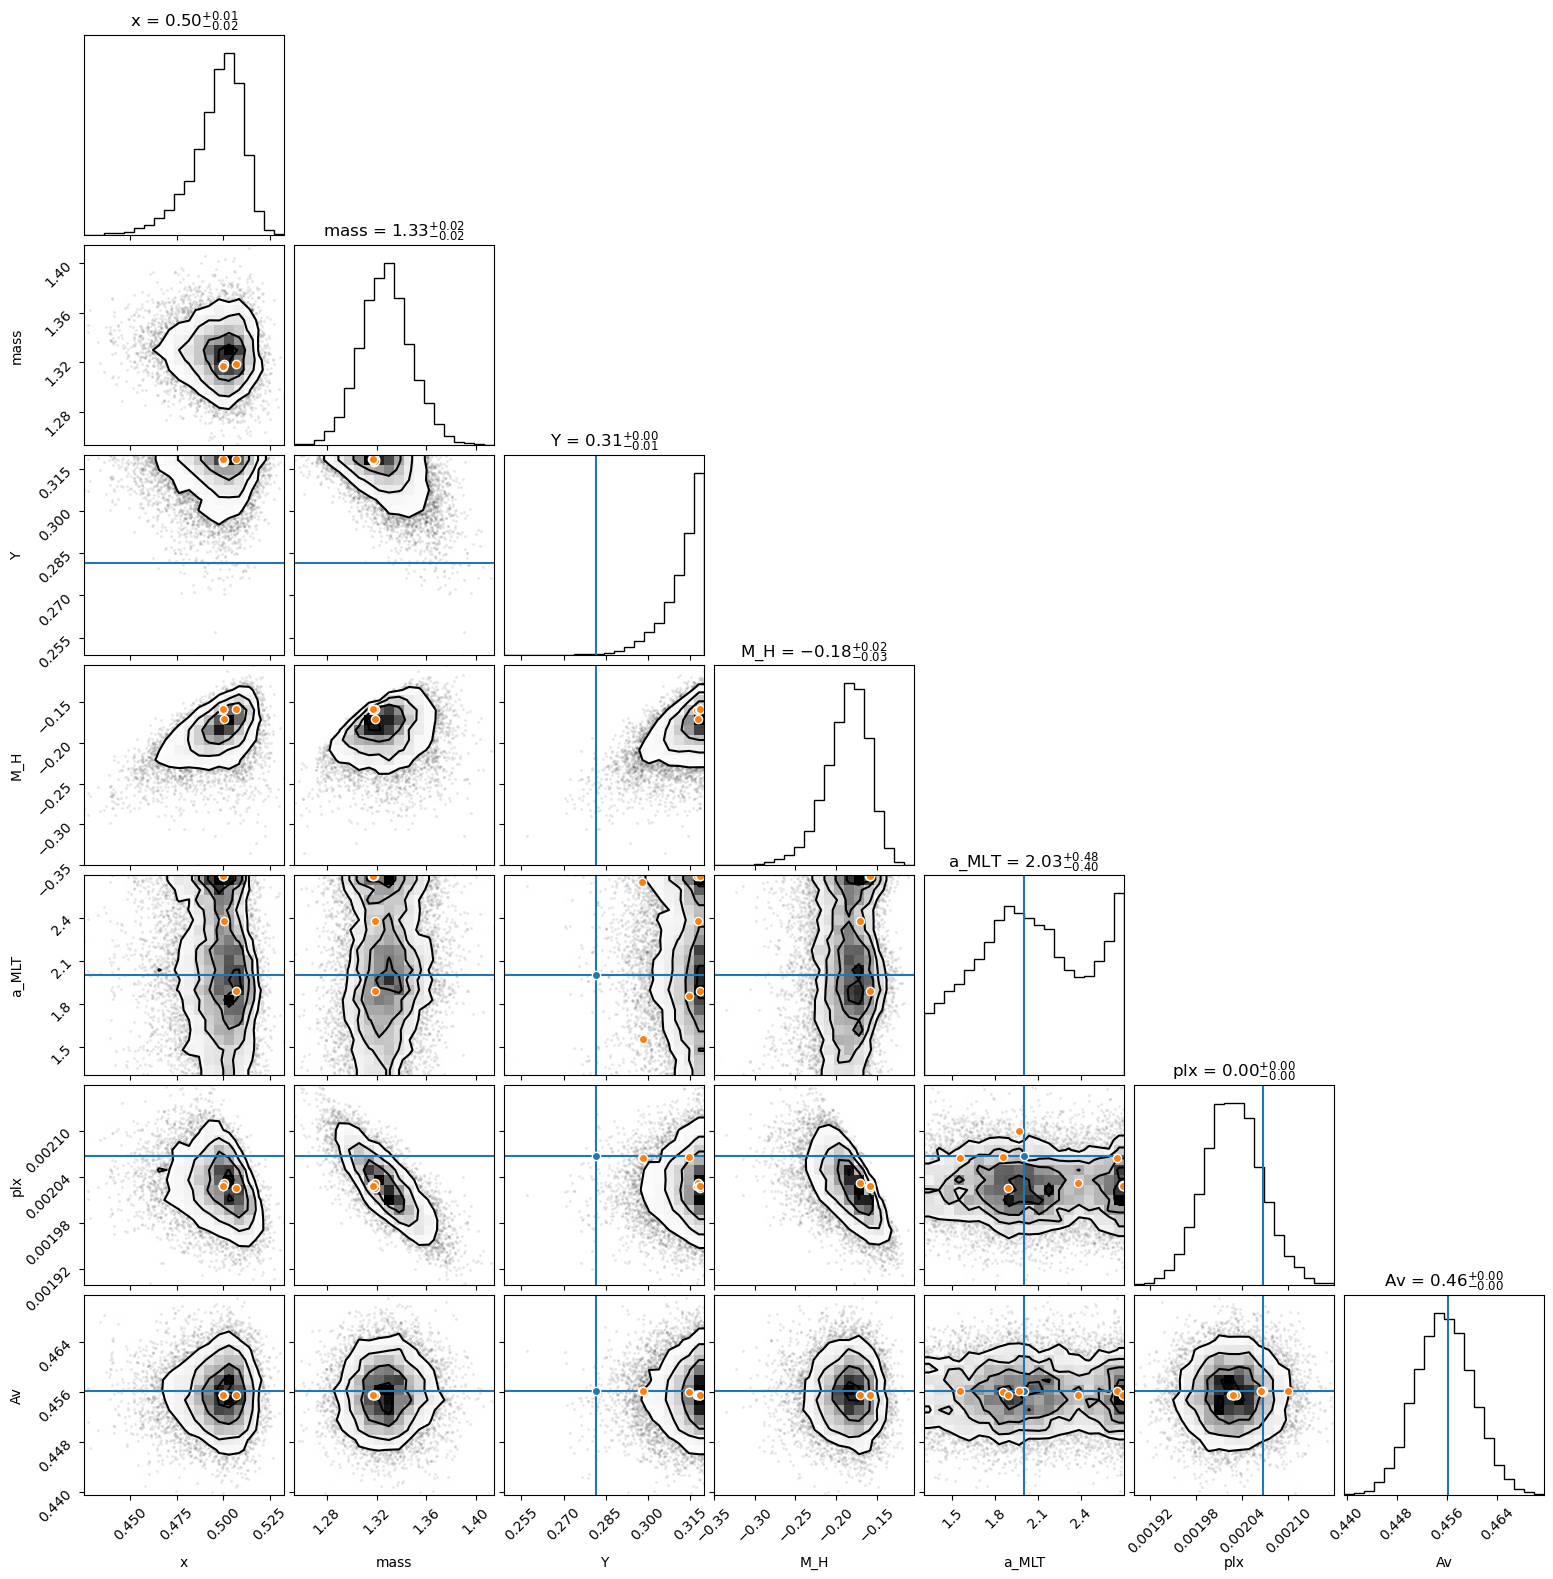

In [22]:
var_names = [
    "x", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT", 
    "plx",
    "Av",
]
divergences_kwargs = dict(c="C2", marker="o", markeredgecolor="white")

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs=divergences_kwargs,
    show_titles=True,
)

xs = np.array([truths[k][i] for k in var_names])
overplot_lines(fig, xs, c="C0")
overplot_points(fig, xs.reshape((1, -1)), c="C0", marker="o", markeredgecolor="white")

xs = np.stack([init_params[k] for k in var_names], 1)
overplot_points(fig, xs, c="C1", marker="o", markeredgecolor="white")

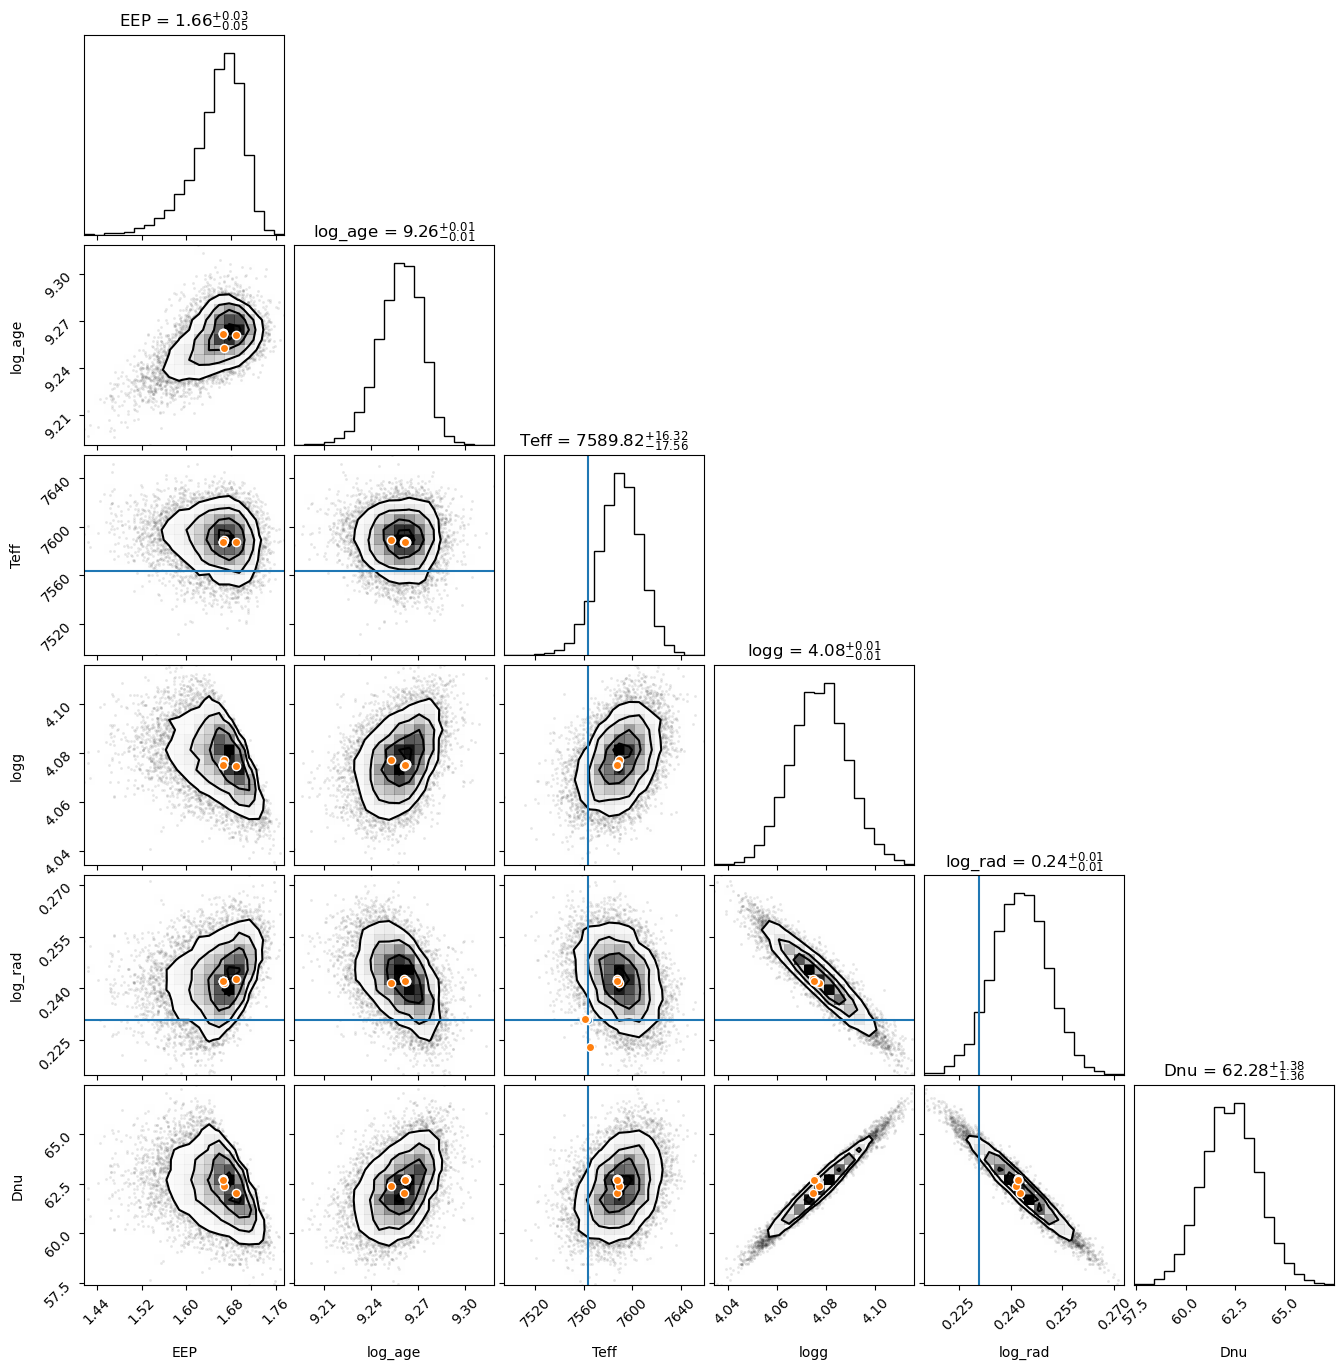

In [23]:
var_names = [
    "EEP", "log_age", "Teff", "logg", "log_rad", "Dnu"
]

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs=divergences_kwargs,
    show_titles=True,
)

xs = np.array([truths[k][i] for k in var_names])
overplot_lines(fig, xs, c="C0")
overplot_points(fig, xs.reshape((1, -1)), c="C0", marker="o", markeredgecolor="white")

xs = np.stack([init_params[k] for k in var_names], 1)
overplot_points(fig, xs, c="C1", marker="o", markeredgecolor="white")

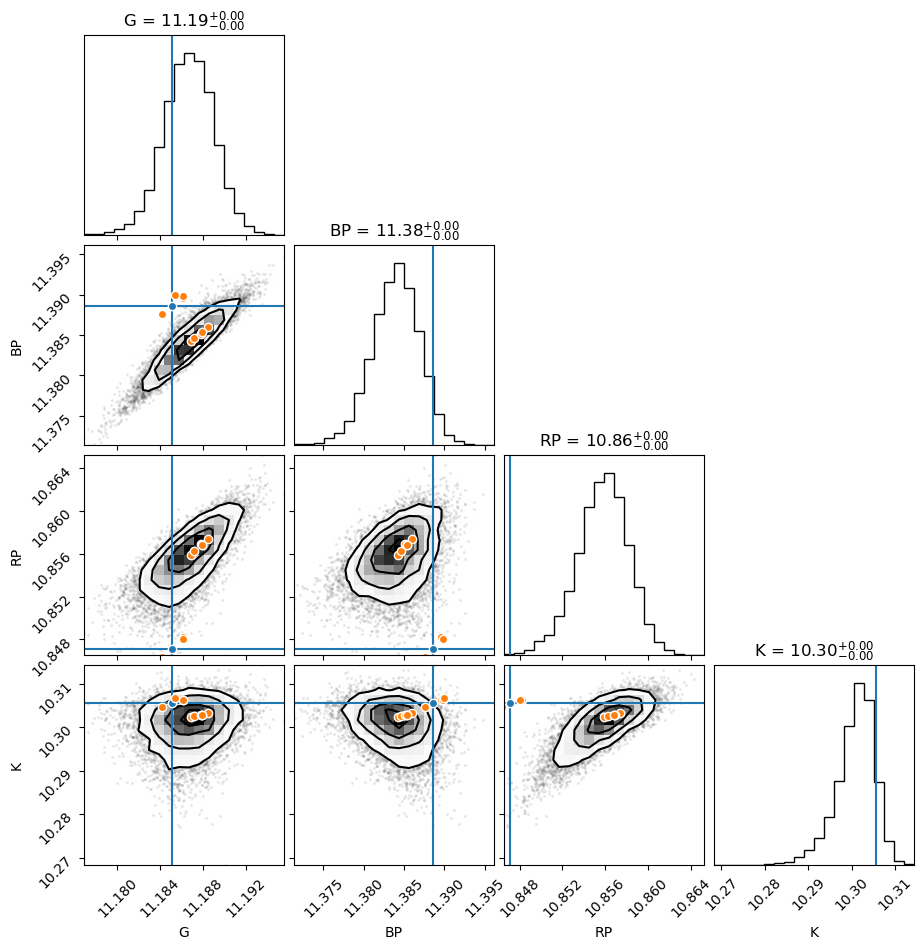

In [24]:
var_names = model.bands

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs=divergences_kwargs,
    show_titles=True,
)

xs = np.array([truths[k][i] for k in var_names])
overplot_lines(fig, xs, c="C0")
overplot_points(fig, xs.reshape((1, -1)), c="C0", marker="o", markeredgecolor="white")

xs = np.stack([init_params[k] for k in var_names], 1)
overplot_points(fig, xs, c="C1", marker="o", markeredgecolor="white")

In [25]:
from numpyro.contrib.nested_sampling import UniformReparam
from numpyro.infer.util import log_density

In [26]:
rng, key = random.split(rng)
# reparam the model so that latent sites have Uniform(0, 1) priors
trace = handlers.trace(handlers.seed(model, key)).get_trace(const, obs=obs)
param_names = [
    site["name"]
    for site in trace.values()
    if site["type"] == "sample"
    and not site["is_observed"]
    and site["infer"].get("enumerate", "") != "parallel"
]
deterministics = [
    site["name"]
    for site in trace.values()
    if site["type"] == "deterministic"
]
reparam_model = handlers.reparam(
    model, config={k: UniformReparam() for k in param_names}
)

In [27]:
import dynesty
import jax
import dynesty.plotting as dyplot
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty.utils import resample_equal

In [28]:
base_names = [f"{name}_base" for name in param_names]

@jax.jit
def prior_transform(u):
    return u

@jax.jit
def log_likelihood(x):
    params = dict(zip(base_names, x))
    return log_density(reparam_model, (const, obs), {}, params)[0]

In [29]:
ndim = len(param_names)
# ns = NestedSampler(log_likelihood, prior_transform, ndim, nlive=1000, sample="rwalk")
ns = DynamicNestedSampler(log_likelihood, prior_transform, ndim, nlive=1000, sample="rwalk")

In [30]:
ns.run_nested()

23366it [00:47, 493.67it/s, batch: 3 | bound: 2 | nc: 1 | ncall: 518968 | eff(%):  4.288 | loglstar: 16.131 < 19.426 < 16.568 | logz:  6.740 +/-  0.085 | stop:  0.957]              


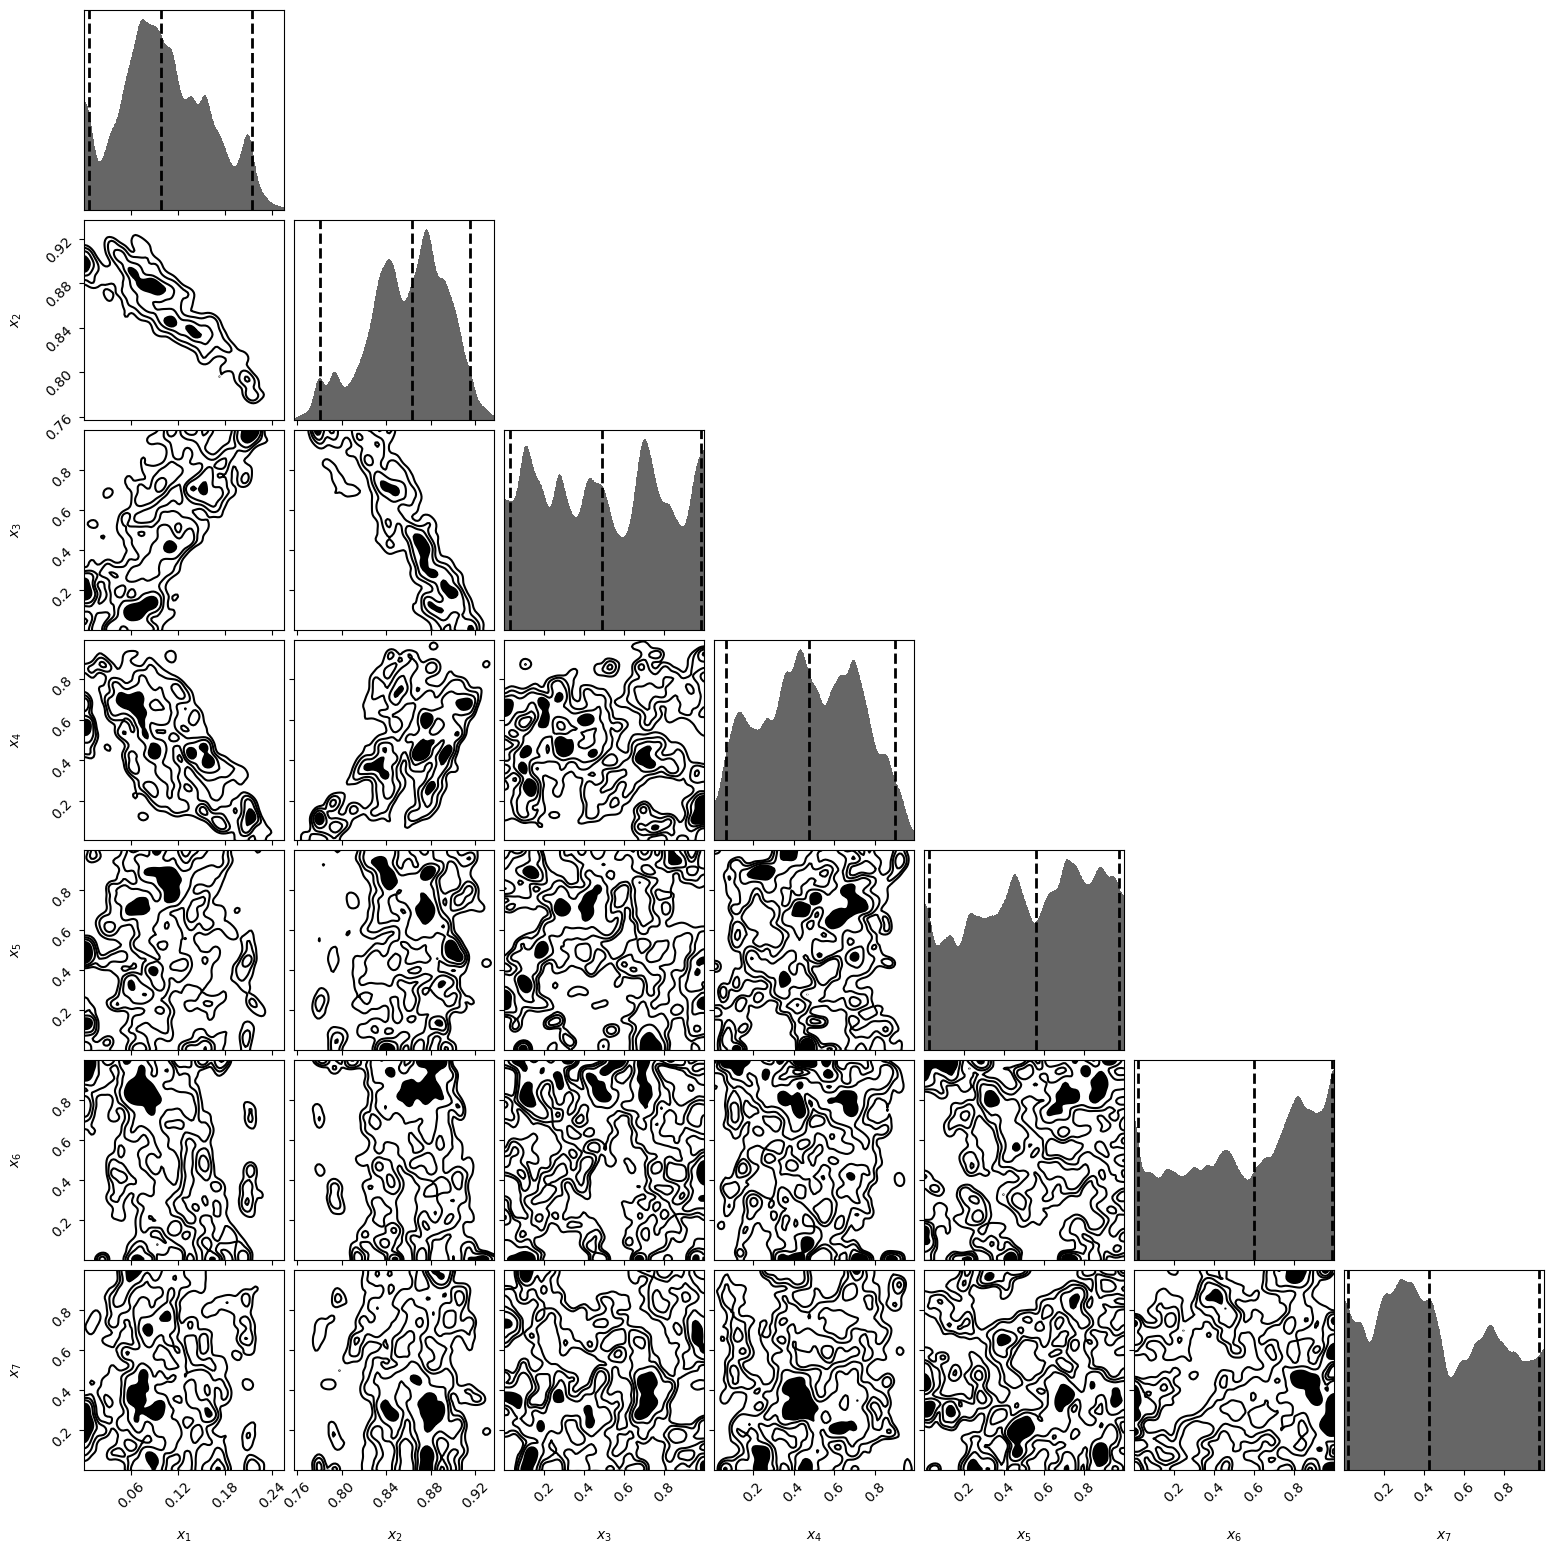

In [31]:
dyplot.cornerplot(ns.results);

In [32]:
samples = ns.results.samples_equal()
samples = dict(zip(base_names, samples.T))

In [33]:
rng, key = random.split(rng)
predict = Predictive(reparam_model, samples)
posterior = predict(key, const)
mask = posterior["age"] < 14e9
posterior = {key: value[mask] for key, value in posterior.items()}

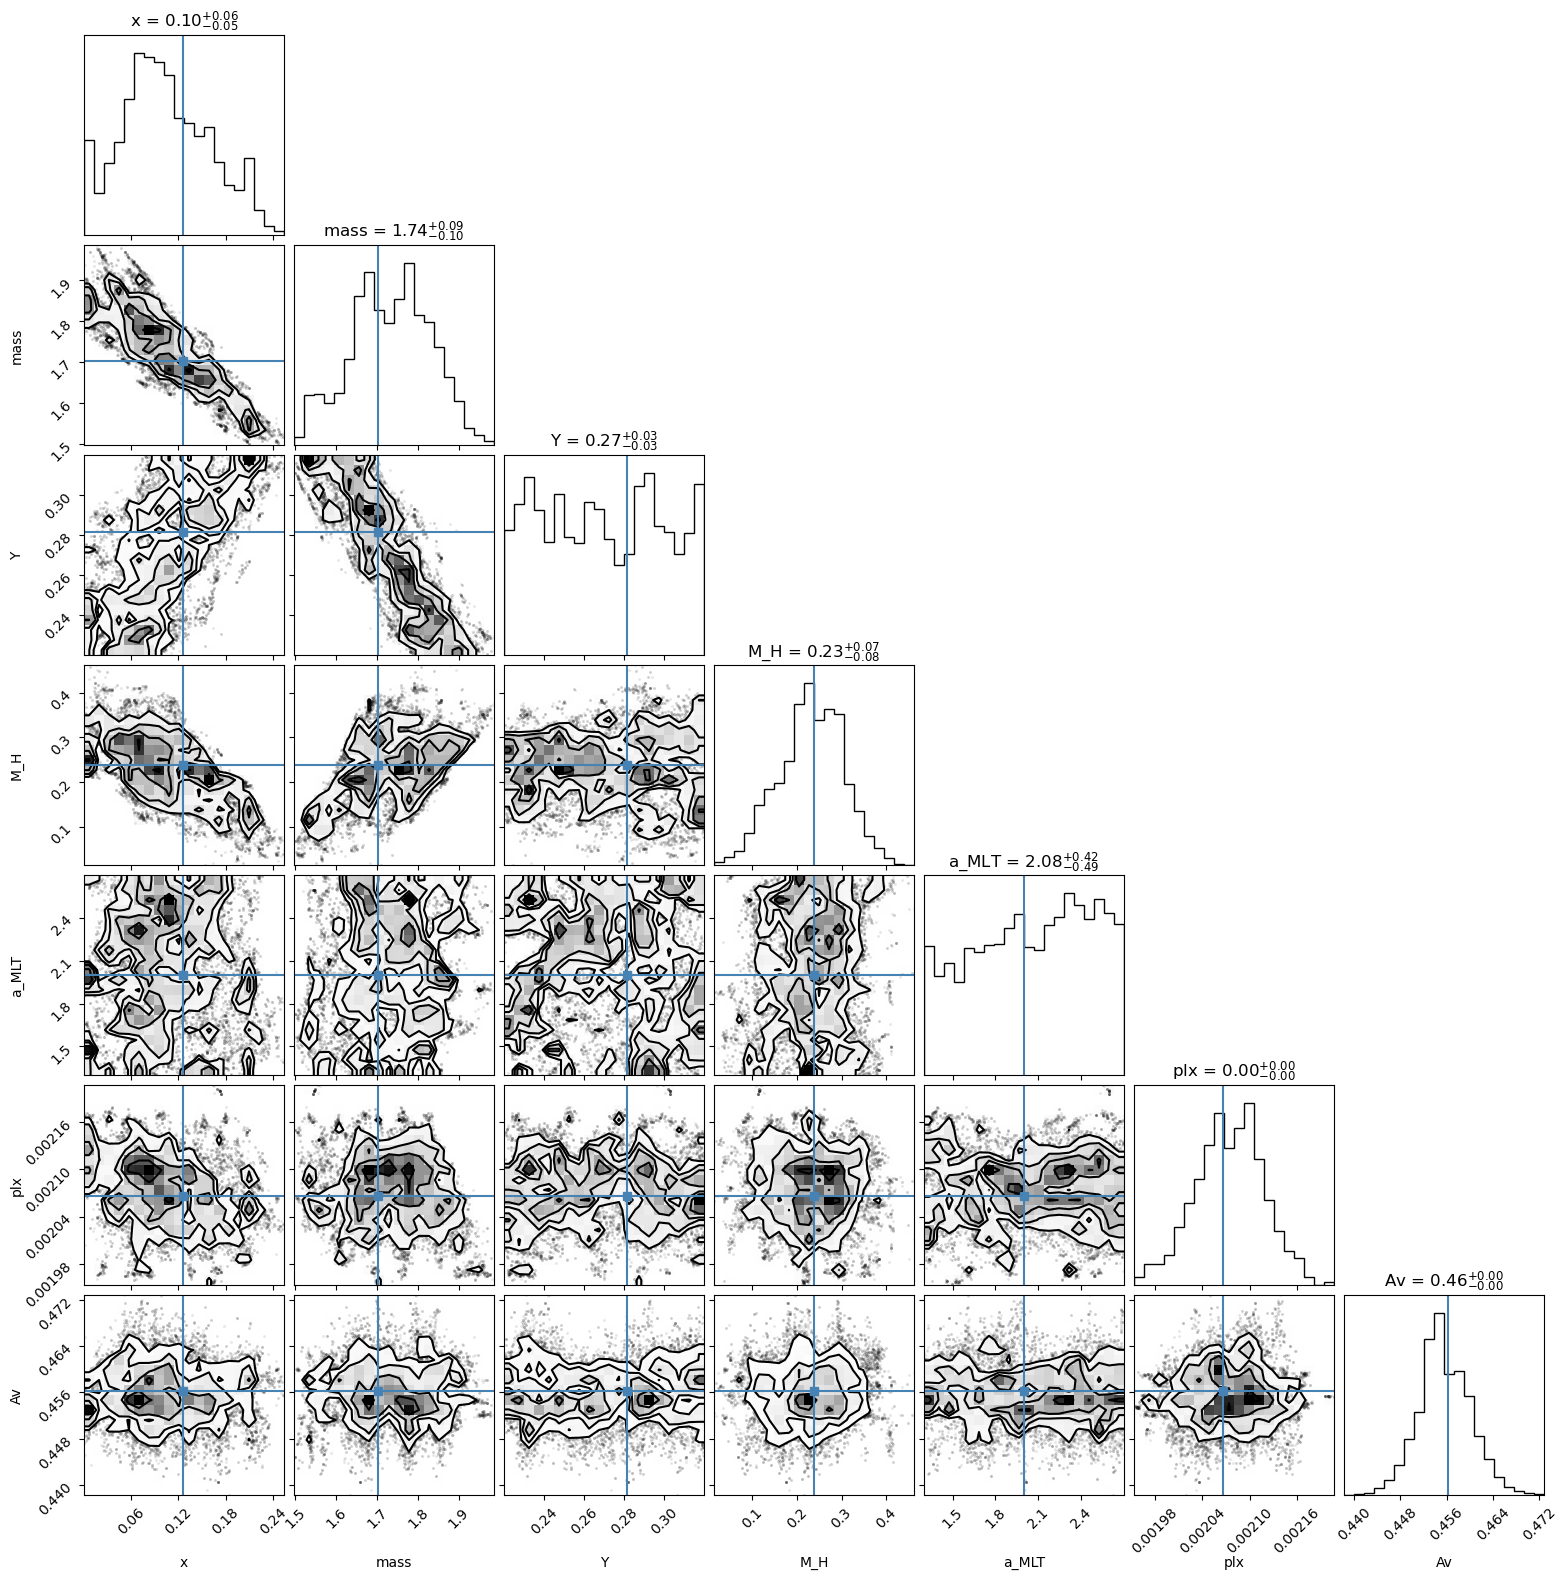

In [34]:
var_names=["x", "mass", "Y", "M_H", "a_MLT", "plx", "Av"]

fig = corner(
    posterior, 
    var_names=var_names, 
    truths={k: truths[k][i] for k in var_names},
    show_titles=True,
)

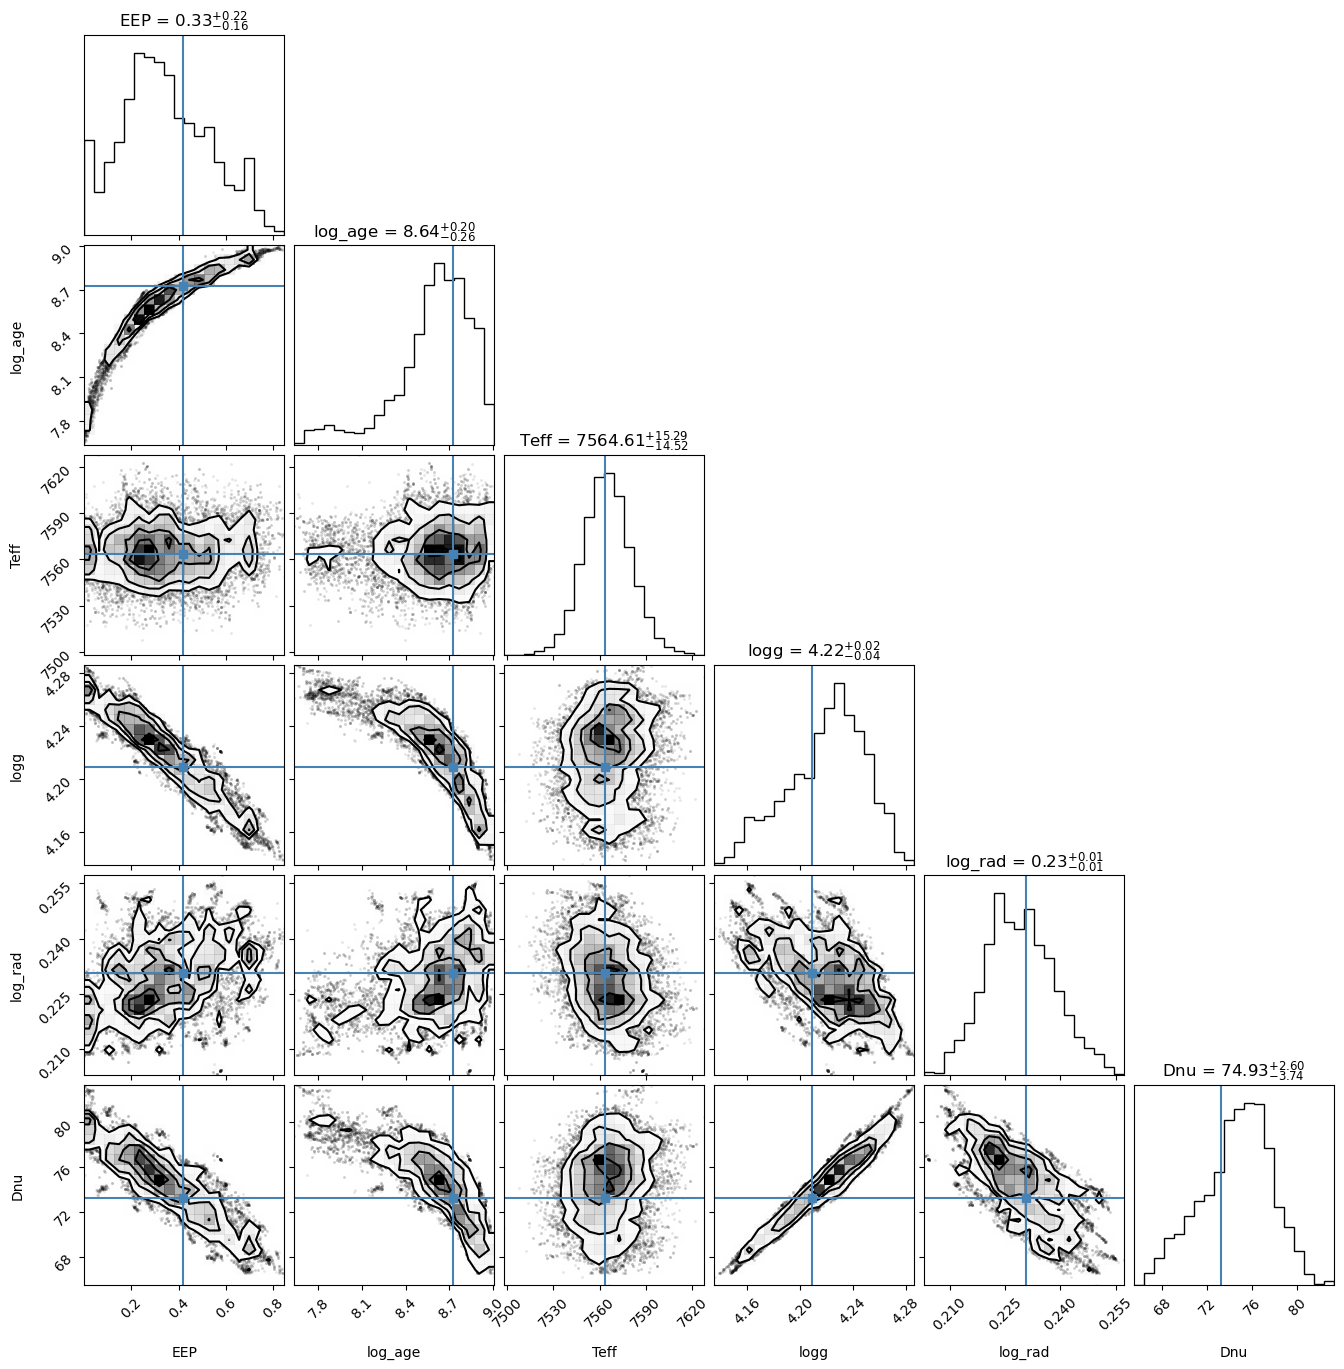

In [35]:
var_names = [
    "EEP", "log_age", "Teff", "logg", "log_rad", "Dnu"
]

fig = corner(
    posterior, 
    var_names=var_names, 
    truths={k: truths[k][i] for k in var_names},
    show_titles=True,
)

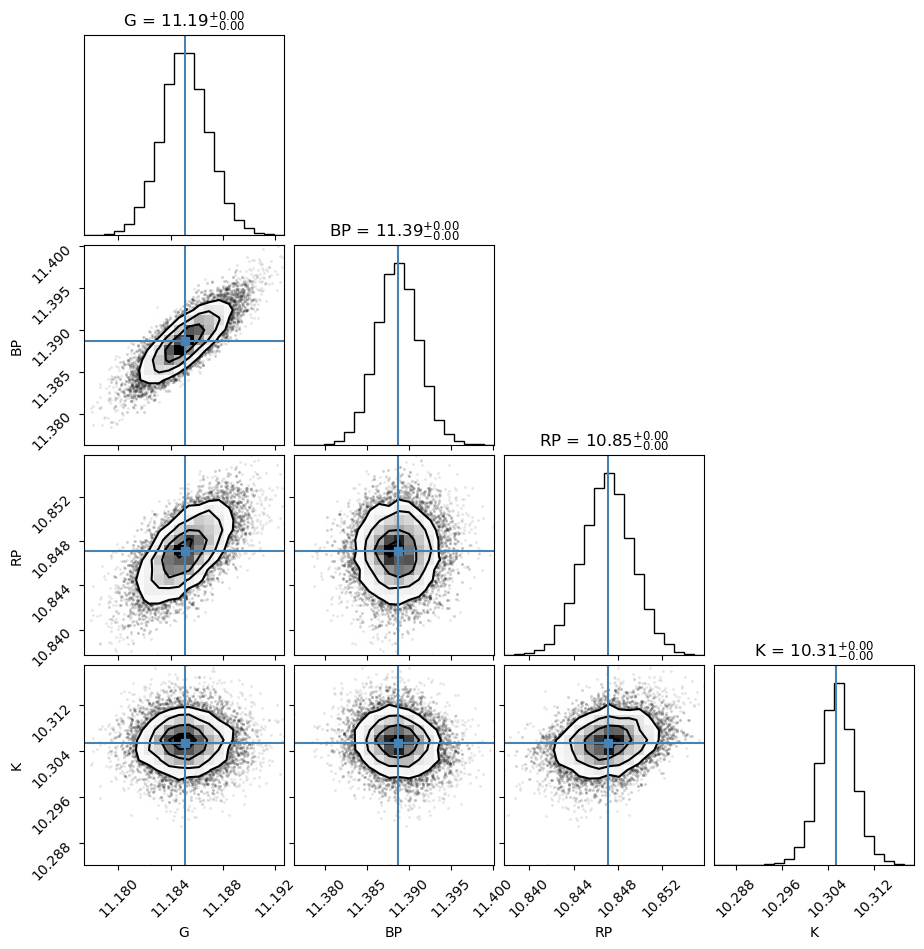

In [36]:
var_names = model.bands

fig = corner(
    posterior, 
    var_names=var_names, 
    truths={k: truths[k][i] for k in var_names},
    show_titles=True,
)